In [1]:
%load_ext autoreload
%autoreload 2
from plot_utils import *

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\U

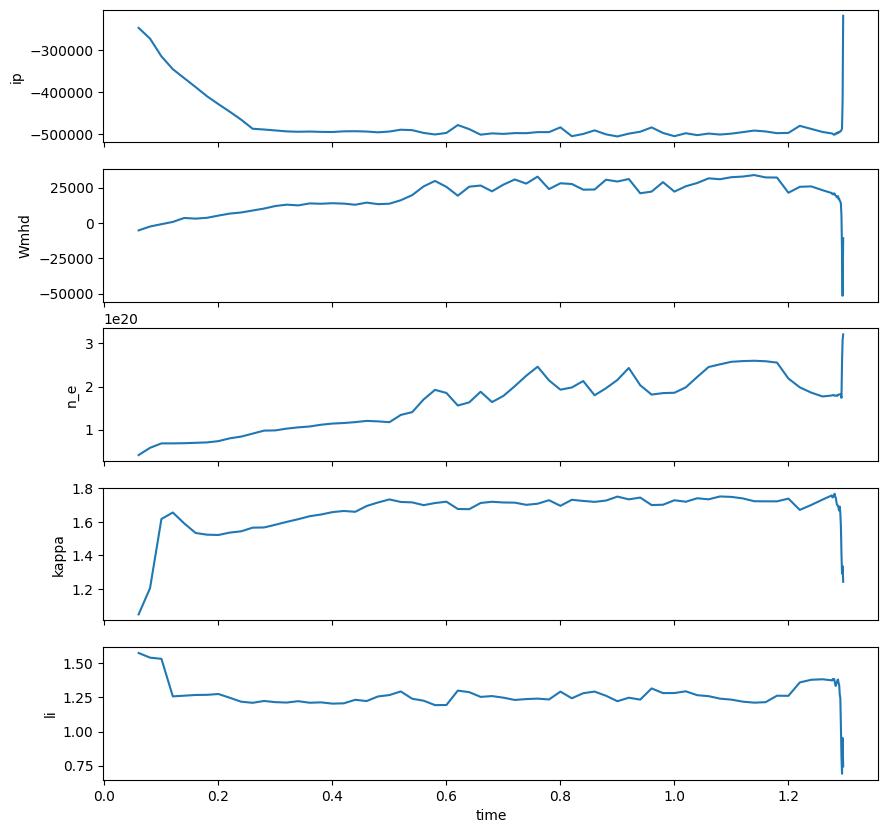

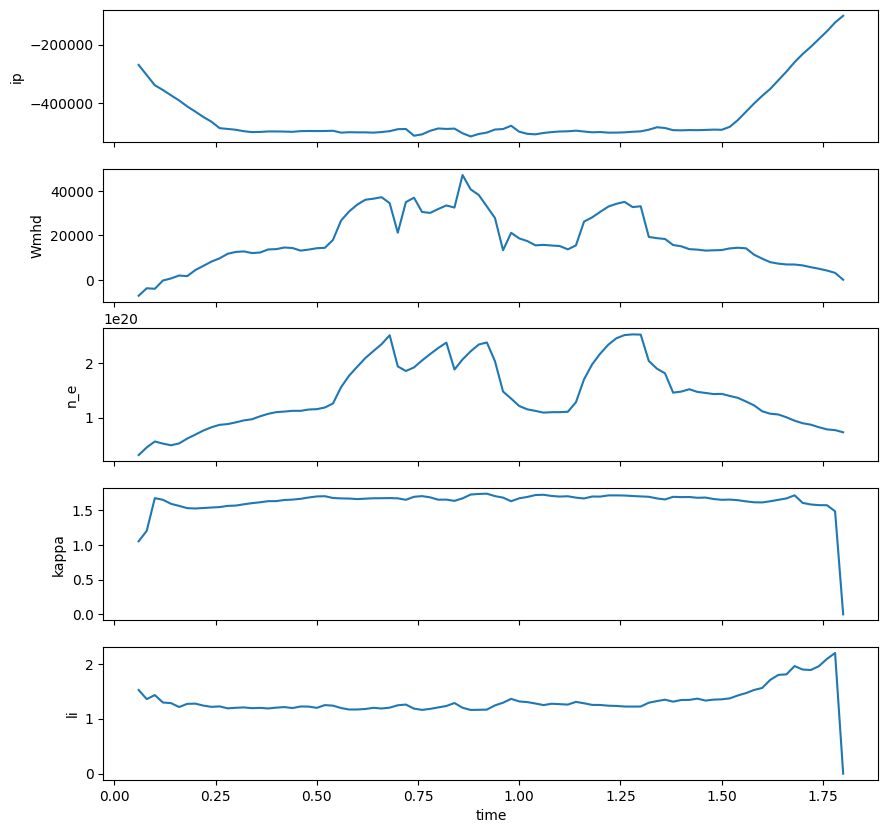

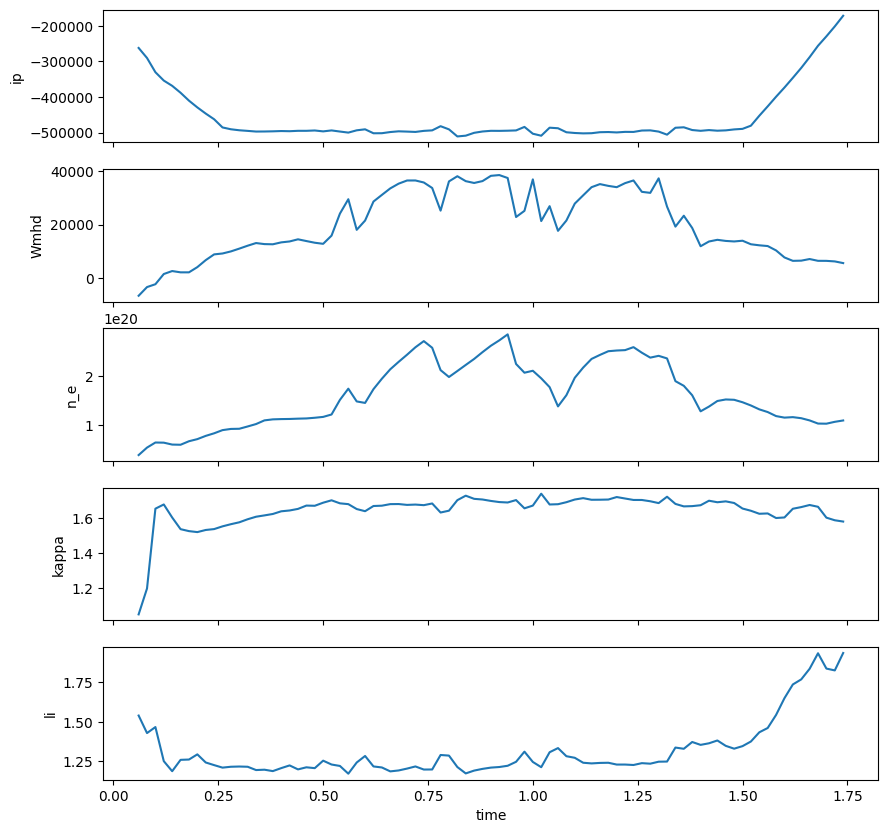

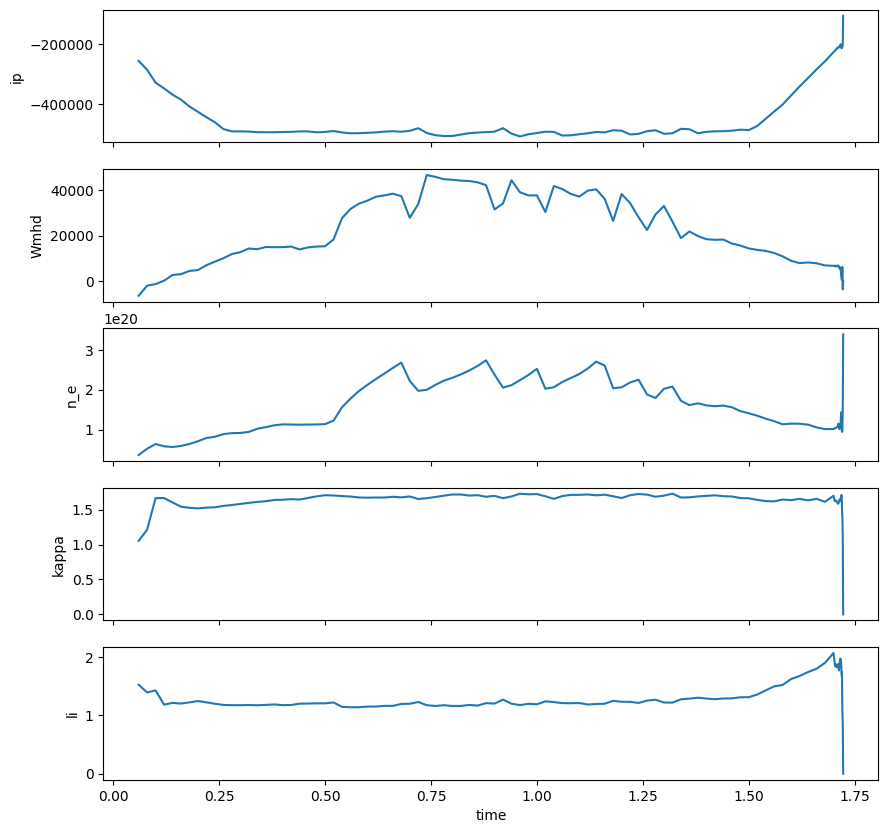

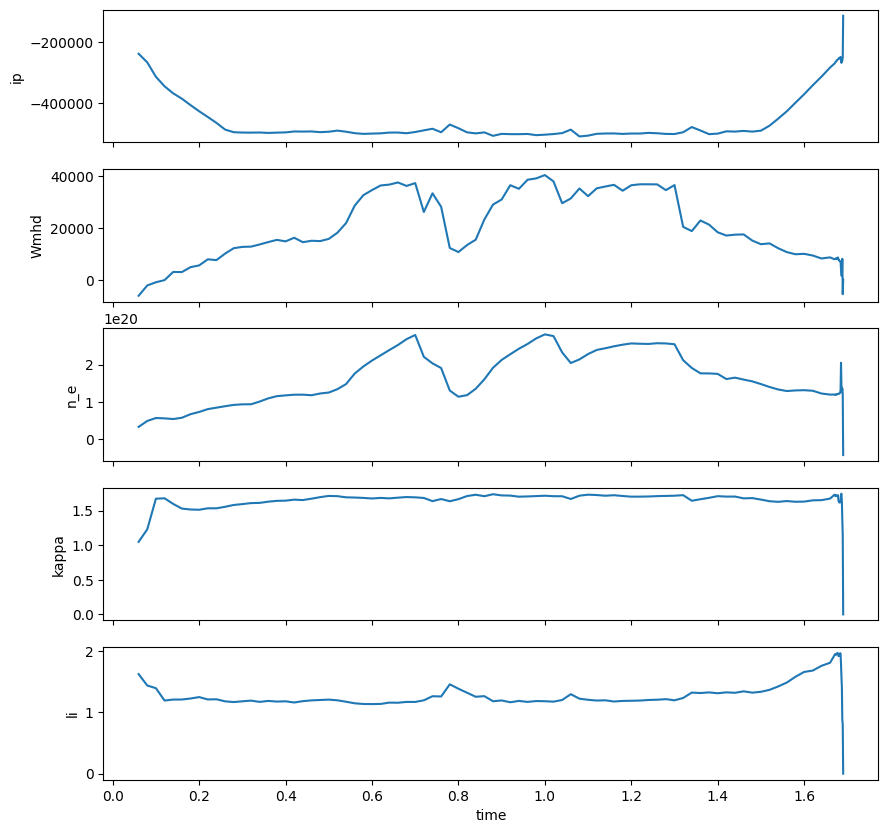

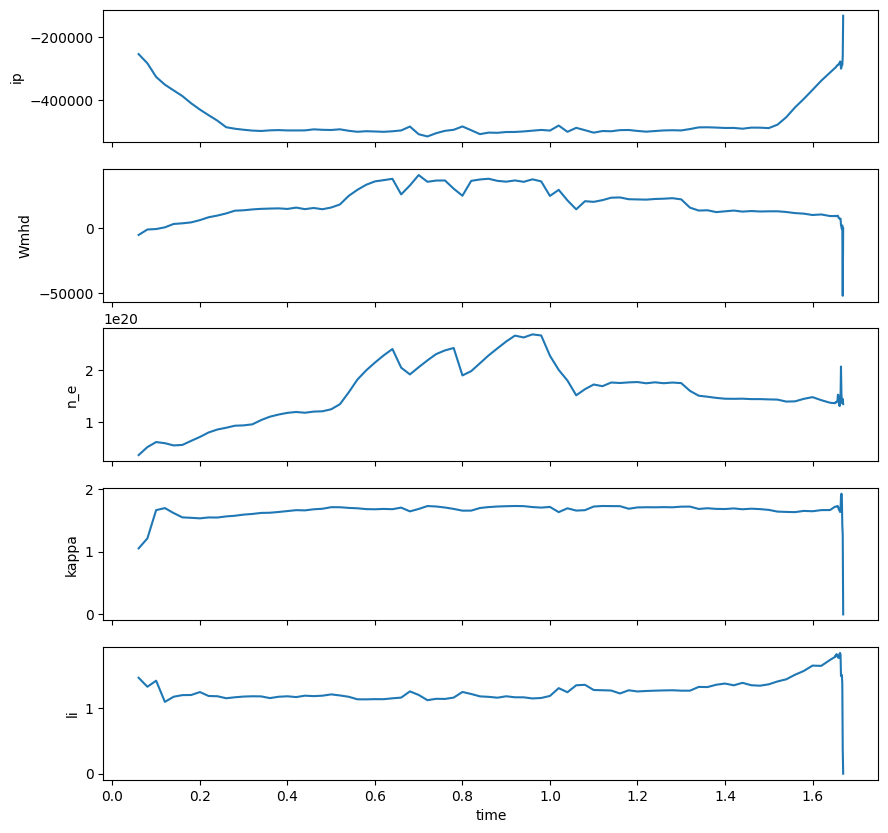

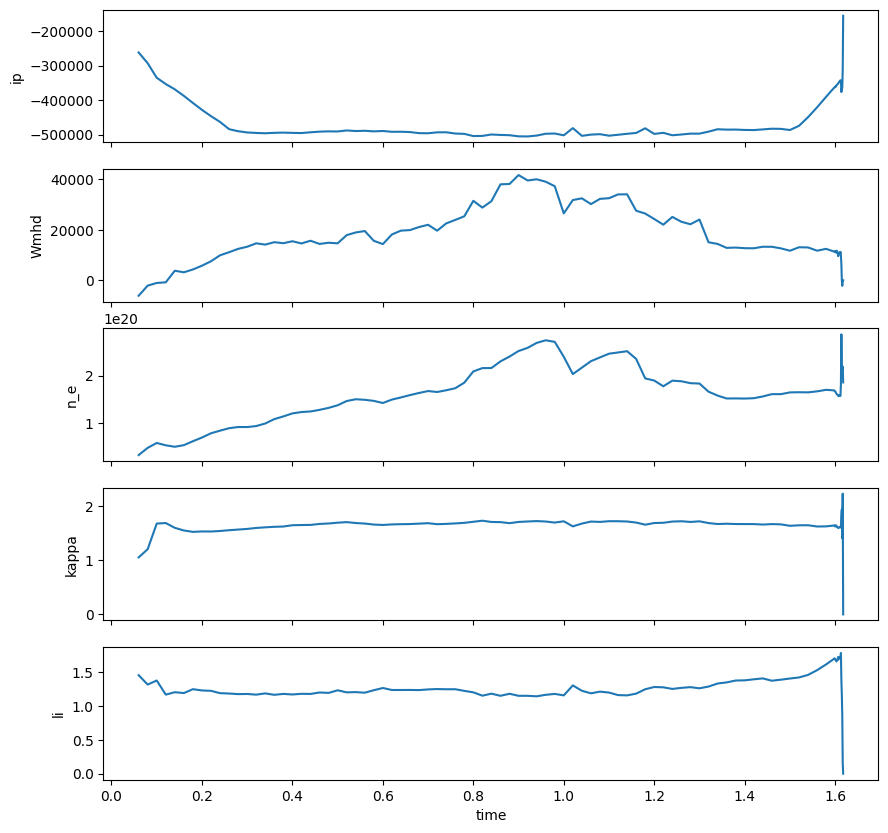

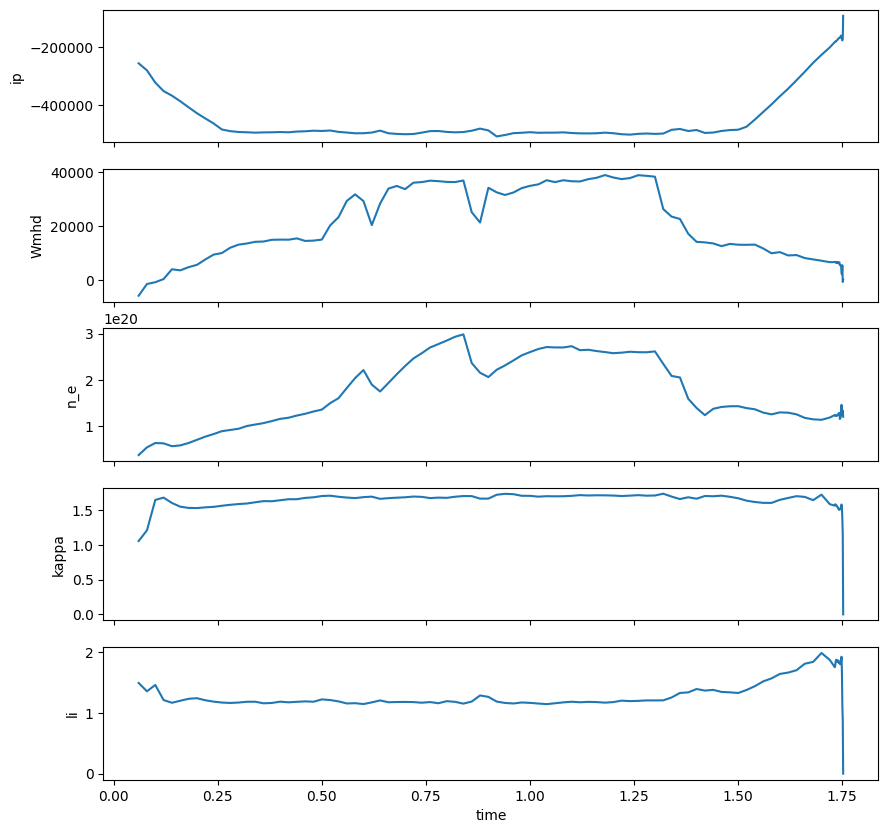

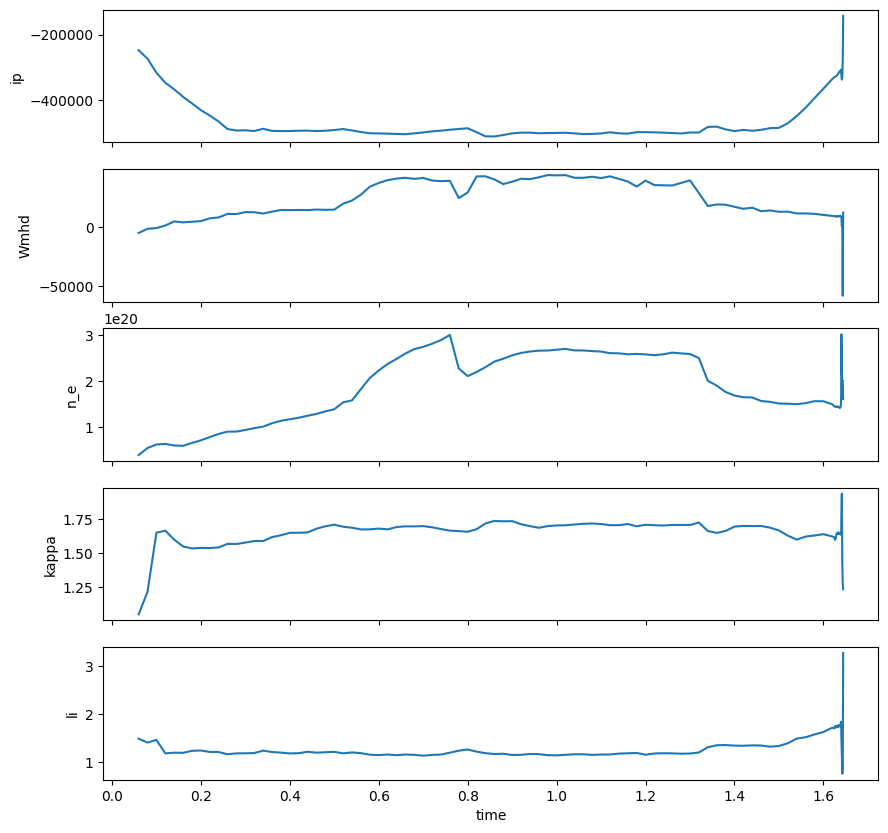

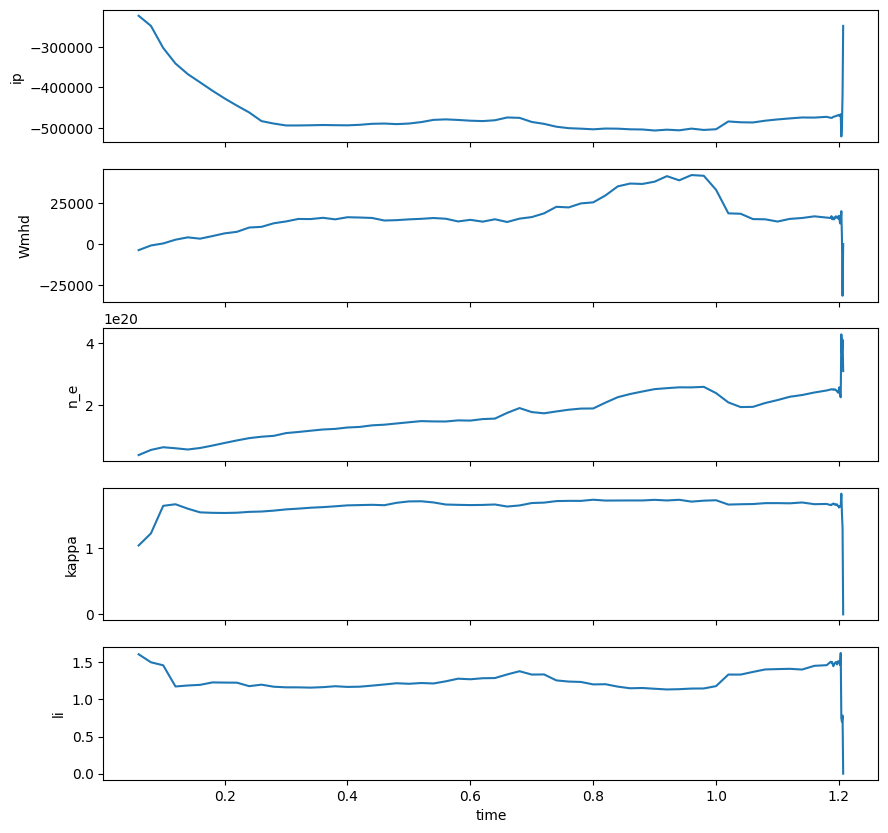

In [2]:
shotlist = [1150805012, 1150805013, 1150805014, 1150805015, 1150805016, 1150805017, 1150805019, 1150805020, 1150805021, 1150805022]

for shot in shotlist:
    plot_shot('cmod', 'small_set', shot)

In [14]:

num_feats = ['ip','Wmhd','n_e','kappa','li']

outcomes, features, full = load_dataset(dataset='small_set', device='cmod')
display(features.head(5))

for outcome in outcomes['time']:
    if outcome <= 0:
        print('negative time')
        print(outcome)

,ip,Wmhd,n_e,kappa,li
0,-269384.705112,-7217.250977,3.084064e+19,1.053295,1.522709
1,-262156.822185,-6645.878906,3.768581e+19,1.051553,1.540107
2,-246348.277069,-5298.565430,4.083797e+19,1.048052,1.576628
3,-255915.493945,-6255.334961,3.589878e+19,1.051934,1.527218
4,-236969.343750,-6172.763184,3.286142e+19,1.048138,1.626651


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 564
Number of validation data points: 188
Number of test data points: 189


In [16]:
from auton_survival.preprocessing import Preprocessor

# Fit the imputer and scaler to the training data and transform the training, validation and test data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
transformer = preprocessor.fit(features, cat_feats=[], num_feats=num_feats,
                                one_hot=True, fill_value=-1)
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

In [22]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'l2' : [1e-3, 1e-4]}
params = ParameterGrid(param_grid)

# Define the times for model evaluation
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 0.9, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('cph', random_seed=2, l2=param['l2'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

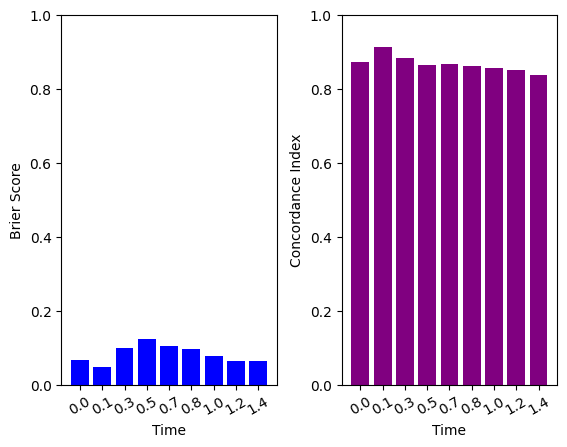

In [23]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)